In [1]:
from matplotlib.gridspec import GridSpec
from netCDF4 import Dataset
import matplotlib
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import LogNorm
import numpy as np
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.colors as mcols
import glob 
import netCDF4
from scipy.interpolate import interp2d
import matplotlib.gridspec as gridspec
from colorspacious import cspace_converter
import pathlib
from pathlib import Path
import numpy.ma as ma
from numpy import genfromtxt
import pandas as pd
from IPython.core.pylabtools import figsize
from scipy import stats

# Purpose of this notebook
This summer, I was investigating how atmospheric rivers (ARs) physically connected to [Madden-Julian Oscillation (MJO)](https://www.climate.gov/news-features/blogs/enso/what-mjo-and-why-do-we-care) might be characteristically different from ones that are not. The goal is to see if water vapor from the MJO could make ARs that make landfall on the West Coast of North America rainier and more likley to cause flood. I currently have a database of AR systems from 1998 through the spring of 2022. Since ARs connected to the MJO, but make landfall on the West Coast are just the ones in the Northern Pacific, I first wanted to determine if ARs in the North Pacific are characteristically different than those globally. The first step here is saying if the maximum area of each AR system is different. I already have a csv that has the list of ARs that are in the North Pacific and the global list, but I'll include those code snippets at the bottom from the .py file that does that. For this one I want to focus on some other manipulation of the data.

### Note
This is A LOT of data I processed just for this one figure and my group has good amount of compute power. On a less powerful system, it would be wise to break the csv files down into lengths of ten and work with those.

## The AR Data itself
Here I'm using xarray to simply show how the AR data I'm using defined and looks

In [6]:
ar_eg = xr.open_dataset('/home/disk/orca/csmall3/AR_testing_research/LPT_ARs/hourly_res/5N_5S_AR_outputs/data/AR/g0_0h/thresh1/systems/1998050100_1999043023/lpt_system_mask_AR.lptid00039.4000.nc')

In [7]:
#if we open the data outright with xarray, we can explore the type of data encoded in these AR system files
ar_eg

<xarray.Dataset>
Dimensions:                                 (lat: 721, lon: 1440, time: 455,
                                             n: 1)
Coordinates:
  * n                                       (n) int32 1
  * time                                    (time) datetime64[ns] 1998-06-17T...
  * lon                                     (lon) float32 0.0 0.25 ... 359.8
  * lat                                     (lat) float32 90.0 89.75 ... -90.0
Data variables: (12/29)
    grid_area                               (lat, lon) float32 ...
    centroid_lon                            (time) float64 ...
    centroid_lat                            (time) float64 ...
    area                                    (time) float64 ...
    largest_object_centroid_lon             (time) float64 ...
    largest_object_centroid_lat             (time) float64 ...
    ...                                      ...
    zonal_propagation_speed                 (n) float64 ...
    meridional_propagation_speed            (n) float64 ...
    mask_at_end_time                        (time, lat, lon) int8 ...
    mask_with_filter_at_end_time            (time, lat, lon) int8 ...
    mask_at_end_time_with_rain              (time, lat, lon) float32 ...
    mask_with_filter_at_end_time_with_rain  (time, lat, lon) float32 ...

1. _n_ just refers to the number AR systems in this data. There's only one.
2. _time_ tells you which dates and times are encoded in this netCDF. This data is at hourly resolution
3. Then we have the _lon_ and _lat_. This is 0.25 degree data as it was built from ERA5 Reanlysis


Then we have our numerous data variables. A deeper explainer is shown [here](https://github.com/brandonwkerns/lpt-python-public).

## Loading in the CSV Data
Here I'll load in my CSV data that has the lists of the Northern Pacific ARs and then global ARs.

In [2]:
Nor_Pac_df = pd.read_csv('/home/disk/orca/csmall3/AR_testing_research/Text_data/hourly_ARs/Deg_5_Match/Pac_5_Deg_AR_RMM.csv')
Nor_Pac_df = Nor_Pac_df.drop(columns=['Unnamed: 0']) #if you bring in this data as is, you'll have an uneccesary column that I'm dropping

In [12]:
#let's see what the csv data looks like
Nor_Pac_df.head()

,AR ID,Date,AR-MJO Overlap?,datetime,RMM Index,RMM Amplitude,In Pac. Basin?
0,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.20861,True
1,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.20861,True
2,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.20861,True
3,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.20861,True
4,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.20861,True


In [13]:
#how many do we have
len(Nor_Pac_df)

1968

_RMM Index_ and _RMM Amplitude_ refere to the [RMM Index](https://journals.ametsoc.org/view/journals/mwre/132/8/1520-0493_2004_132_1917_aarmmi_2.0.co_2.xml) to determine the phase of the MJO. [Many studies](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL090983) have used the MJO Phase to determine possible impacts on AR rainfall. I wanted to keep this info in my data for cross comparison in future work.

When I was doing a deeper analysis on my AR systems I noticed that the method I used to create them led to some extremely long-lived, and ultimately unphysical ARs. The code below filters out ARs greater than 576 hours which is the 90th percentile duration for the entire global data set. The code below takes **forever** (5 minutes) to run!

In [3]:
Nor_Pac_area = []
for i in range(0,len(Nor_Pac_df)):
    ar_test = xr.open_dataset(Nor_Pac_df['AR ID'].iloc[i])
    if ar_test['duration'].values > 576:
        print("AR too long")
    else:
        area = ar_test['maxarea'].values
        Nor_Pac_area += [area]

Nor_Pac_area = np.array(Nor_Pac_area)
Nor_Pac_area = np.concatenate(Nor_Pac_area) #make it a straight array

AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR too long
AR t

In [8]:
len(Nor_Pac_area) #let's see how many systems we retain after dropping the ones that are too long

1481

In [17]:
#knowing statistics is important!
print(Nor_Pac_area.mean())
print(Nor_Pac_area.max())
print(Nor_Pac_area.min())
print(np.median(Nor_Pac_area))

7650806.215226199
25748672.0
890779.0
6026333.0


Let's pull in all the ARs globally

In [10]:
all_df = pd.read_csv('/home/disk/orca/csmall3/AR_testing_research/Text_data/hourly_ARs/Deg_5_Match/All_5_Deg_AR_RMM_LPT_90_per.csv')
all_df = all_df.drop(columns=['Unnamed: 0'])

In [14]:
all_df.head()

,AR ID,Date,AR-MJO Overlap?,datetime,RMM Index,RMM Amplitude
0,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.208610
1,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.208610
2,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-05-29T00:00:00,False,1998-05-29 00:00:00,6.0,1.208610
3,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-08-23T15:00:00,False,1998-08-23 15:00:00,2.0,1.005930
4,/home/disk/orca/csmall3/AR_testing_research/LP...,1998-09-15T10:00:00,False,1998-09-15 10:00:00,3.0,0.574379


In [15]:
len(all_df)

8127

### Note
I already preprocessed the global data so it excludes ARs greater than 576 hours in duration

In [11]:
x_5 = []
for i in range(0,len(all_df)):
    ar_test = xr.open_dataset(all_df['AR ID'].iloc[i])

    area = ar_test['maxarea'].values
    x_5 += [area]

x_5 = np.array(x_5)
x_5 = np.concatenate(x_5) #takes almost 4 minutes to process

In [16]:
#knowing statistics is important!
print(x_5.mean())
print(x_5.max())
print(x_5.min())
print(np.median(x_5))

5420433.769618248
28843110.0
769349.625
4137770.0


Now I want to plot my data as a boxplot so I can visually determine if ARs in the Pacific Basin than those in globally

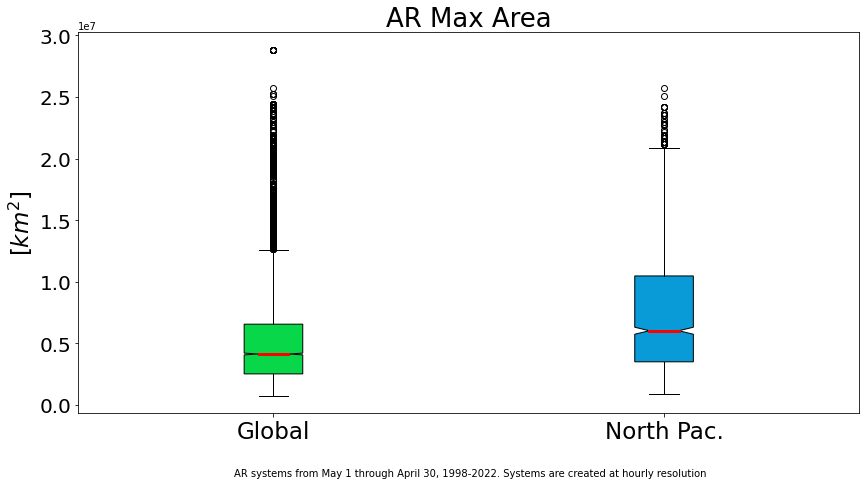

In [18]:
#plot the box plot
ticksize =20
legendsize=23
legbox = 19
titlesize = 26

fig, ax = plt.subplots(figsize=[14, 7])
data_area = [x_5,Nor_Pac_area]
type_labels = ['Global', 'North Pac.']

bp=ax.boxplot(data_area, notch=True, patch_artist = True)
colors = ['#08D74A', '#089BD7']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
# plt.legend(fontsize=str(legbox))
plt.yticks(fontsize=ticksize)
plt.xticks(fontsize=ticksize)

ax.set_xticklabels(type_labels, fontsize = legendsize)
ax.set_title('AR Max Area', fontsize=titlesize)
ax.set_ylabel('[$km^{2}$]', fontsize=legendsize)
plt.figtext(0.28, 0, 'AR systems from May 1 through April 30, 1998-2022. Systems are created at hourly resolution', wrap=True)
fig.savefig("/home/disk/orca/csmall3/public_html/AR_Testing/Summer_Plots/hourly_res/ivt_dist/Nor_Pac_AR_Max_Area_90_Per_1hr.png", dpi=350, bbox_inches='tight')
plt.show()

## T test
I can visually look at the box plot and see that North Pacific ARs are larger (many reasons for this, including the MJO as a large vapor source and that the Pacific is large basin), but let's be sure that those differences are significant. A [student t test](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6813708/) will let us see if our results actually have signficant difference. But we need to see if our results have equal variance first!

In [19]:
# very different variance
print(np.var(Nor_Pac_area))
print(np.var(x_5))

29534567507477.58
19159662398554.05


In [20]:
print(stats.ttest_ind(Nor_Pac_area, x_5, equal_var=False))
#super low p value so we're good and our ARs are different sizes

Ttest_indResult(statistic=14.931122641802633, pvalue=1.1165773425247956e-47)
